In [ ]:
! pip install flowMC==0.4.0
! pip install corner

In [11]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jaxtyping import Float, Array
from typing import Any
from flowMC.resource_strategy_bundles import RQSpline_MALA_Bundle
from flowMC.Sampler import Sampler
import corner
import numpy as np
import arviz as az
from typing import Any
from flowMC.Sampler import Sampler
import numpy as np
import matplotlib.pyplot as plt

In [23]:
class FlowMCExperimentRunner:
    def __init__(self):
        self.params = {}
        self.samplers = {}
        self.show_initial_positions = False
        self.experiment_type = None  # 'gaussian', 'dualmoon', 'rosenbrock'

    def collect_user_input(self):
        def ask(prompt, cast_type, default=None):
            while True:
                value = input(f"{prompt} " + (f"[Default={default}]: " if default is not None else ": "))
                if value == "" and default is not None:
                    return default
                try:
                    if cast_type == list:
                        result = eval(value)
                        return list(result) if isinstance(result, (list, tuple)) else [result]
                    return cast_type(value)
                except Exception:
                    print("Invalid input. Try again.")

        def ask_yes_no(prompt):
            while True:
                response = input(f"{prompt} (yes/no): ").strip().lower()
                if response in ["yes", "no"]:
                    return response == "yes"
                print("Invalid input. Please enter 'yes' or 'no'.")

        def ask_experiment():
            while True:
                choice = input("Which experiment to run? (gaussian / dualmoon / rosenbrock): ").strip().lower()
                if choice in ["gaussian", "dualmoon", "rosenbrock"]:
                    return choice
                print("Invalid experiment name. Choose: gaussian / dualmoon / rosenbrock.")

        self.experiment_type = ask_experiment()
        self.params["n_dims"] = ask("Please provide number of dimensions", int)
        self.params["n_local_steps"] = ask("Please provide number of local steps", int, 20)
        self.params["n_global_steps"] = ask("Please provide number of global steps", int, 10)
        self.params["n_training_loops"] = ask("Please provide number of training loops", int, 20)
        self.params["n_production_loops"] = ask("Please provide number of production loops", int, 20)
        self.params["n_epochs"] = ask("Please provide number of epochs", int, 5)
        self.params["n_chains"] = ask("Please provide number of chains", int, 20)
        self.params["rq_spline_hidden_units"] = ask("Please provide spline hidden units (e.g., [32, 32])", list, [32, 32])
        self.params["rq_spline_n_bins"] = ask("Please provide number of spline bins", int, 8)
        self.params["rq_spline_n_layers"] = ask("Please provide number of spline layers", int, 4)
        self.params["learning_rate"] = ask("Please provide learning rate", float, 5e-3)
        self.params["batch_size"] = ask("Please provide batch size", int, 10000)
        self.params["n_max_examples"] = ask("Please provide number of maximum examples", int, 10000)

        self.show_initial_positions = ask_yes_no("Do you want to show initial chain positions?")
        self.steps_to_run = ask("How many experiments with different local steps do you want to run?", int)
        self.want_plots = ask_yes_no("Do you want to plot diagnostics and corner plots?")
        self.want_data_print = ask_yes_no("Do you want to print data arrays?")

    def target_normal(self, x, data):
        return -0.5 * jnp.sum(x**2)

    def target_dual_moon(self, x: jnp.ndarray, data: dict[str, Any]) -> jnp.ndarray:
        term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
        term2 = -0.5 * ((x[0] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
        term3 = -0.5 * ((x[1] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
        return -(term1 - logsumexp(term2) - logsumexp(term3))

    def target_rosenbrock(self, x: jnp.ndarray, data: dict[str, Any]) -> jnp.ndarray:
        return -jnp.sum(100.0 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def run_experiment(self, local_steps):
        if self.experiment_type == "gaussian":
            return self._run_sampler(local_steps, self.target_normal)
        elif self.experiment_type == "dualmoon":
            return self._run_sampler(local_steps, self.target_dual_moon)
        elif self.experiment_type == "rosenbrock":
            return self._run_sampler(local_steps, self.target_rosenbrock)

    def _run_sampler(self, local_steps, target_fn):
        dim = self.params["n_dims"]
        rng_key = jax.random.PRNGKey(42)
        rng_key, subkey = jax.random.split(rng_key)
        initial_position = jax.random.normal(subkey, shape=(self.params["n_chains"], dim))

        if self.show_initial_positions:
            print("Initial chain positions were:")
            print(initial_position)

        data = {"data": jnp.arange(dim).astype(jnp.float32)}

        bundle = RQSpline_MALA_Bundle(
            subkey,
            self.params["n_chains"],
            dim,
            target_fn,
            local_steps,
            self.params["n_global_steps"],
            self.params["n_training_loops"],
            self.params["n_production_loops"],
            self.params["n_epochs"],
            mala_step_size=1e-1,
            rq_spline_hidden_units=self.params["rq_spline_hidden_units"],
            rq_spline_n_bins=self.params["rq_spline_n_bins"],
            rq_spline_n_layers=self.params["rq_spline_n_layers"],
            learning_rate=self.params["learning_rate"],
            batch_size=self.params["batch_size"],
            n_max_examples=self.params["n_max_examples"],
            verbose=False
        )

        sampler = Sampler(
            dim,
            self.params["n_chains"],
            rng_key,
            resource_strategy_bundles=bundle,
        )
        sampler.sample(initial_position, data)
        return sampler

    #def run_multiple_experiments(self, steps):
        #for step in range(1, steps + 1):
            #print(f"Running step={step}")
            #self.samplers[step] = self.run_experiment(local_steps=step)

    def run_multiple_experiments(self, steps):
        base_steps = self.params["n_local_steps"]
        for i in range(steps):
            local_steps = base_steps + i
            print(f"Running experiment with local_steps={local_steps}")
            self.samplers[local_steps] = self.run_experiment(local_steps=local_steps)

    def plot_diagnostics(self):
        steps = list(self.samplers.keys())
        n_steps = len(steps)
        fig, axes = plt.subplots(n_steps, 3, figsize=(18, 5 * n_steps))

        # Ensure axes is always 2D
        if n_steps == 1:
            axes = np.expand_dims(axes, axis=0)

        for i, step in enumerate(steps):
            sampler = self.samplers[step]
            local_accs = sampler.resources["local_accs_production"].data
            global_accs = sampler.resources["global_accs_production"].data
            log_prob = sampler.resources["log_prob_production"].data

            mean_local_accs = np.mean(local_accs, axis=0)
            mean_global_accs = np.mean(global_accs, axis=0)

            axes[i][0].plot(mean_local_accs)
            axes[i][0].set_title(f"Local Acceptance Rate (Step={step})")

            axes[i][1].plot(mean_global_accs)
            axes[i][1].set_title(f"Global Acceptance Rate (Step={step})")

            axes[i][2].plot(log_prob[::5, ::20].T, lw=1, alpha=0.5)
            axes[i][2].set_title(f"Log Probability (Step={step})")

        plt.tight_layout()
        plt.show()

    def plot_corner(self):
        for step, sampler in self.samplers.items():
            chains = sampler.resources["positions_production"].data
            nf_samples = sampler.resources["model"].sample(jax.random.PRNGKey(2046), 10000)
            labels = [f"x{i}" for i in range(self.params["n_dims"])]

            fig = plt.figure(figsize=(6, 6))
            corner.corner(np.array(chains.reshape(-1, self.params["n_dims"])), fig=fig, labels=labels)

            fig = plt.figure(figsize=(6, 6))
            corner.corner(np.array(nf_samples), fig=fig, labels=labels)

    def print_data(self):
        for step, sampler in self.samplers.items():
            print(f"Step {step}")
            local_accs = sampler.resources["local_accs_production"].data
            global_accs = sampler.resources["global_accs_production"].data
            log_prob = sampler.resources["log_prob_production"].data
            print("Local Accs:", local_accs)
            print("Global Accs:", global_accs)
            print("Log Prob:", log_prob)

Which experiment to run? (gaussian / dualmoon / rosenbrock): rosenbrock
Please provide number of dimensions : 3
Please provide number of local steps [Default=20]: 20
Please provide number of global steps [Default=10]: 10
Please provide number of training loops [Default=20]: 20
Please provide number of production loops [Default=20]: 20
Please provide number of epochs [Default=5]: 5
Please provide number of chains [Default=20]: 20
Please provide spline hidden units (e.g., [32, 32]) [Default=[32, 32]]: 32, 32
Please provide number of spline bins [Default=8]: 8
Please provide number of spline layers [Default=4]: 4
Please provide learning rate [Default=0.005]: 0.005
Please provide batch size [Default=10000]: 10000
Please provide number of maximum examples [Default=10000]: 10000
Do you want to show initial chain positions? (yes/no): yes
How many experiments with different local steps do you want to run? : 2
Do you want to plot diagnostics and corner plots? (yes/no): yes
Do you want to print 

Tuning Phase:   0%|          | 0/20 [00:00<?, ?it/s]

Compiling MALA body


Sampling Phase:   0%|          | 0/20 [00:00<?, ?it/s]

Compiling MALA body


Sampling Phase: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Running experiment with local_steps=21
Initial chain positions were:
[[ 0.60576403  0.7990441  -0.908927  ]
 [-0.63525754 -1.2226585  -0.83226097]
 [-0.47417238 -1.2504351  -0.17678244]
 [-0.04917514 -0.41177532 -0.39363015]
 [ 1.3116323   0.21555556  0.41164538]
 [-0.28955024 -0.96516913  0.4492738 ]
 [-0.4404279  -0.9279748  -0.27167085]
 [ 0.6813305  -0.48514158  0.5080369 ]
 [-0.14290465  0.08314767  0.7378238 ]
 [ 1.2528664   0.8052585  -1.1102904 ]
 [-0.68016213 -1.5656278  -0.30395982]
 [ 0.3939658  -0.87947404 -2.4562614 ]
 [ 0.93186224 -0.94133425  0.4705041 ]
 [-0.5682559  -0.03568491  0.6551425 ]
 [-0.6771544  -0.22431315 -0.98438984]
 [-2.0855458   1.8307798   0.37856096]
 [ 0.8829633  -0.2824106  -0.27737394]
 [ 1.1645578   0.21666679 -0.38737997]
 [-0.45600188  1.1401342  -0.56761235]
 [ 0.7668255  -0.96149266  0.02561626]]
Resources or strategies not provided. Using resource strategy bundles.


Tuning Phase:   0%|          | 0/20 [00:00<?, ?it/s]

Compiling MALA body


Sampling Phase:   0%|          | 0/20 [00:00<?, ?it/s]

Compiling MALA body


Sampling Phase: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


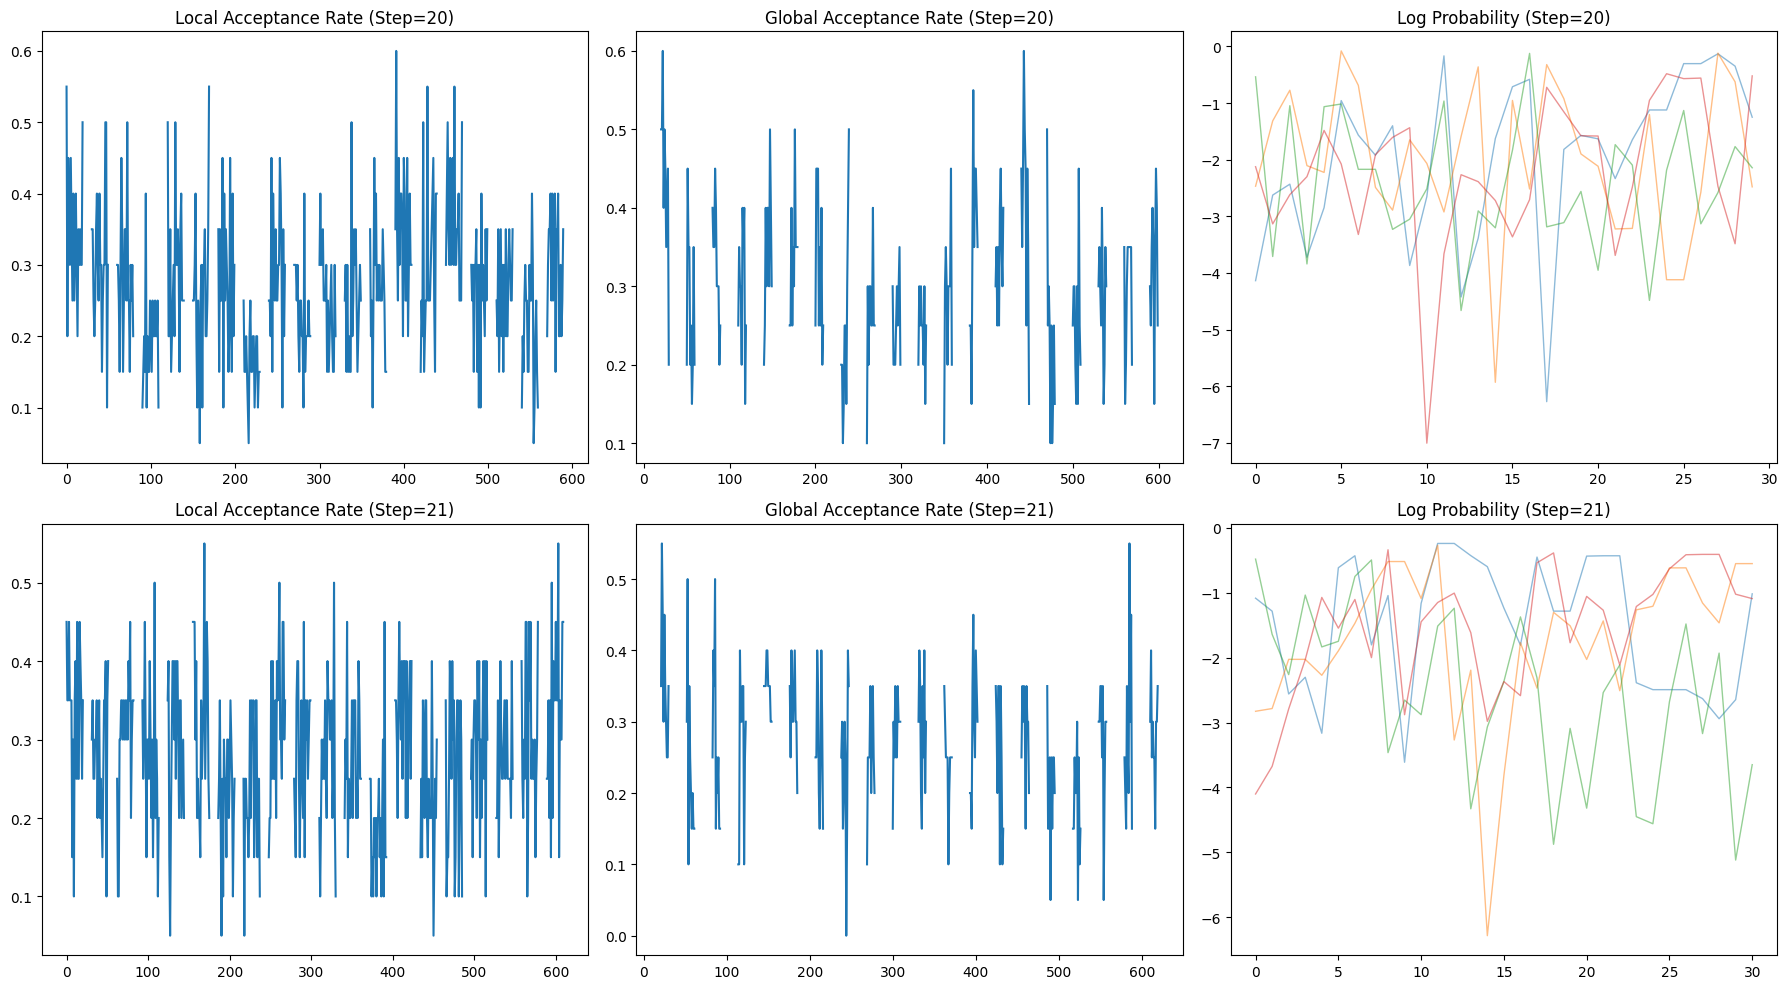

Step 20
Local Accs: [[  1.   1.   0. ... -inf -inf -inf]
 [  1.   0.   1. ... -inf -inf -inf]
 [  0.   0.   1. ... -inf -inf -inf]
 ...
 [  0.   0.   0. ... -inf -inf -inf]
 [  0.   0.   0. ... -inf -inf -inf]
 [  1.   0.   0. ... -inf -inf -inf]]
Global Accs: [[-inf -inf -inf ...   1.   0.   0.]
 [-inf -inf -inf ...   0.   0.   0.]
 [-inf -inf -inf ...   1.   1.   1.]
 ...
 [-inf -inf -inf ...   1.   0.   1.]
 [-inf -inf -inf ...   0.   1.   0.]
 [-inf -inf -inf ...   0.   0.   0.]]
Log Prob: [[-4.1369705  -3.8356812  -3.8356812  ... -3.2086885  -3.2086885
  -3.2086885 ]
 [-2.5436783  -2.5436783  -1.6797022  ... -0.3748489  -0.3748489
  -0.3748489 ]
 [-1.0377401  -1.0377401  -0.939022   ... -2.59126    -2.9304779
  -0.92100054]
 ...
 [-0.6021308  -0.6021308  -0.6021308  ... -2.6579282  -2.6579282
  -0.9387087 ]
 [-0.9894474  -0.9894474  -0.9894474  ... -1.0189704  -1.2823061
  -1.2823061 ]
 [-1.9658964  -1.9658964  -1.9658964  ... -0.9124236  -0.9124236
  -0.9124236 ]]
Step 21
Local A

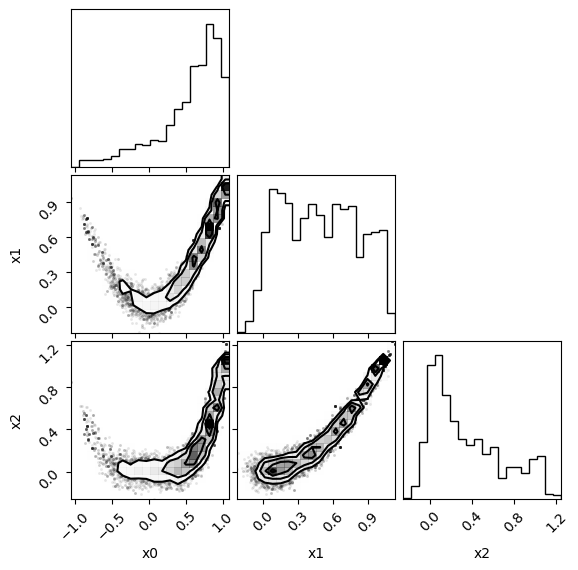

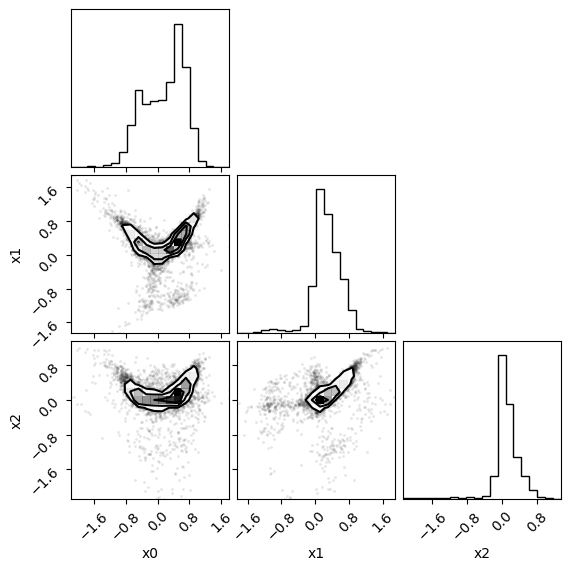

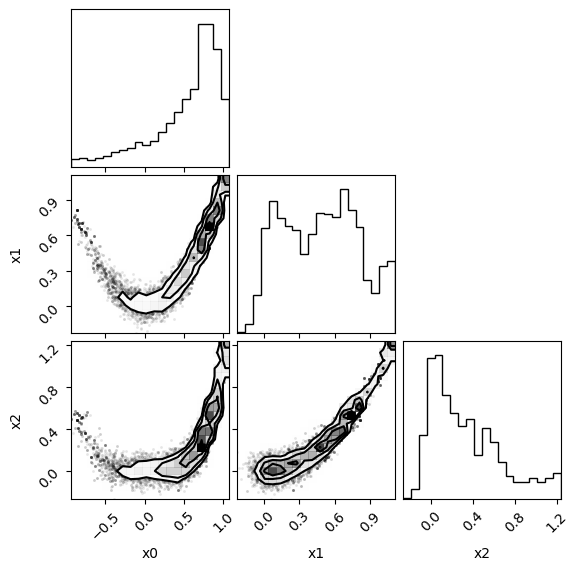

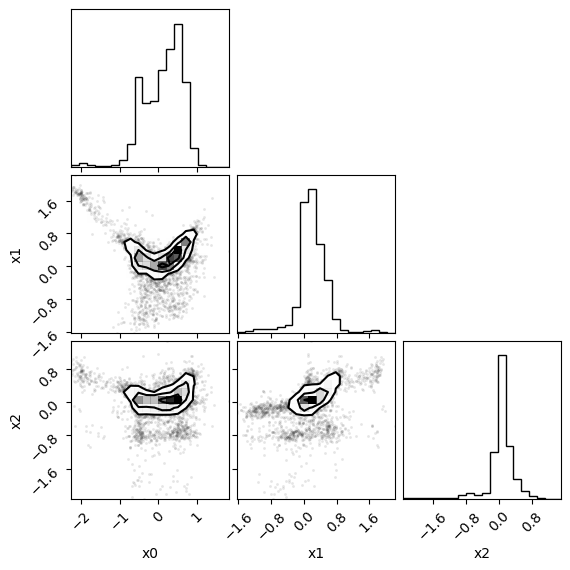

In [26]:
runner = FlowMCExperimentRunner()
runner.collect_user_input()
runner.run_multiple_experiments(runner.steps_to_run)

if runner.want_plots:
    runner.plot_diagnostics()
    runner.plot_corner()

if runner.want_data_print:
    runner.print_data()